# Inference

## Imports & Args

In [1]:
import argparse
import json
import logging
import os
import random
from io import open
import numpy as np
import math
import _pickle as cPickle
from scipy.stats import spearmanr

from tensorboardX import SummaryWriter
from tqdm import tqdm
from bisect import bisect
import yaml
from easydict import EasyDict as edict
import sys
import pdb

import torch
import torch.nn.functional as F
import torch.nn as nn

from vilbert.task_utils import (
    LoadDatasetEval,
    LoadLosses,
    ForwardModelsTrain,
    ForwardModelsVal,
    EvaluatingModel,
)

import vilbert.utils as utils
import torch.distributed as dist

In [2]:
def evaluate(
    args,
    task_dataloader_val,
    task_stop_controller,
    task_cfg,
    device,
    task_id,
    model,
    task_losses,
    epochId,
    default_gpu,
    tbLogger,
):

    model.eval()
    for i, batch in enumerate(task_dataloader_val[task_id]):
        loss, score, batch_size = ForwardModelsVal(
            args, task_cfg, device, task_id, batch, model, task_losses
        )
        tbLogger.step_val(
            epochId, float(loss), float(score), task_id, batch_size, "val"
        )
        if default_gpu:
            sys.stdout.write("%d/%d\r" % (i, len(task_dataloader_val[task_id])))
            sys.stdout.flush()

    # update the multi-task scheduler.
    task_stop_controller[task_id].step(tbLogger.getValScore(task_id))
    score = tbLogger.showLossVal(task_id, task_stop_controller)

In [3]:
def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class GeLU(nn.Module):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return gelu(x)

In [4]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

In [5]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--bert_model",
    default="bert-base-uncased",
    type=str,
    help="Bert pre-trained model selected in the list: bert-base-uncased, "
    "bert-large-uncased, bert-base-cased, bert-base-multilingual, bert-base-chinese.",
)
parser.add_argument(
    "--from_pretrained",
    default="bert-base-uncased",
    type=str,
    help="Bert pre-trained model selected in the list: bert-base-uncased, "
    "bert-large-uncased, bert-base-cased, bert-base-multilingual, bert-base-chinese.",
)
parser.add_argument(
    "--output_dir",
    default="results",
    type=str,
    help="The output directory where the model checkpoints will be written.",
)
parser.add_argument(
    "--config_file",
    default="config/bert_config.json",
    type=str,
    help="The config file which specified the model details.",
)
parser.add_argument(
    "--no_cuda", action="store_true", help="Whether not to use CUDA when available"
)
parser.add_argument(
    "--do_lower_case",
    default=True,
    type=bool,
    help="Whether to lower case the input text. True for uncased models, False for cased models.",
)
parser.add_argument(
    "--local_rank",
    type=int,
    default=-1,
    help="local_rank for distributed training on gpus",
)
parser.add_argument(
    "--seed", type=int, default=42, help="random seed for initialization"
)
parser.add_argument(
    "--fp16",
    action="store_true",
    help="Whether to use 16-bit float precision instead of 32-bit",
)
parser.add_argument(
    "--loss_scale",
    type=float,
    default=0,
    help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
    "0 (default value): dynamic loss scaling.\n"
    "Positive power of 2: static loss scaling value.\n",
)
parser.add_argument(
    "--num_workers",
    type=int,
    default=16,
    help="Number of workers in the dataloader.",
)
parser.add_argument(
    "--save_name", default="", type=str, help="save name for training."
)
parser.add_argument(
    "--use_chunk",
    default=0,
    type=float,
    help="whether use chunck for parallel training.",
)
parser.add_argument(
    "--batch_size", default=30, type=int, help="what is the batch size?"
)
parser.add_argument(
    "--tasks", default="", type=str, help="1-2-3... training task separate by -"
)
parser.add_argument(
    "--in_memory",
    default=False,
    type=bool,
    help="whether use chunck for parallel training.",
)
parser.add_argument(
    "--baseline", action="store_true", help="whether use single stream baseline."
)
parser.add_argument("--split", default="", type=str, help="which split to use.")
parser.add_argument(
    "--dynamic_attention",
    action="store_true",
    help="whether use dynamic attention.",
)
parser.add_argument(
    "--clean_train_sets",
    default=True,
    type=bool,
    help="whether clean train sets for multitask data.",
)
parser.add_argument(
    "--visual_target",
    default=0,
    type=int,
    help="which target to use for visual branch. \
    0: soft label, \
    1: regress the feature, \
    2: NCE loss.",
)
parser.add_argument(
    "--task_specific_tokens",
    action="store_true",
    help="whether to use task specific tokens for the multi-task learning.",
)

_StoreTrueAction(option_strings=['--task_specific_tokens'], dest='task_specific_tokens', nargs=0, const=True, default=False, type=None, choices=None, help='whether to use task specific tokens for the multi-task learning.', metavar=None)

## load the textual input

In [6]:
args = parser.parse_args(['--bert_model', 'bert-base-uncased',
                          '--from_pretrained', 'save/VQA_bert_base_6layer_6conect-finetune_from_multi_task_model/pytorch_model_19.bin',
                          '--config_file', 'config/bert_base_6layer_6conect.json',
                          '--tasks', '19',
                          '--split', 'trainval_dc', # this is the deep captions training split
                          '--save_name', 'task-19',
                          '--task_specific_tokens',
                          '--batch_size', '128'])

In [7]:
with open("vilbert_tasks.yml", "r") as f:
    task_cfg = edict(yaml.safe_load(f))

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if args.baseline:
    from pytorch_transformers.modeling_bert import BertConfig
    from vilbert.basebert import BaseBertForVLTasks
else:
    from vilbert.vilbert import BertConfig
    from vilbert.vilbert import VILBertForVLTasks

task_names = []
for i, task_id in enumerate(args.tasks.split("-")):
    task = "TASK" + task_id
    name = task_cfg[task]["name"]
    task_names.append(name)

# timeStamp = '-'.join(task_names) + '_' + args.config_file.split('/')[1].split('.')[0]
timeStamp = args.from_pretrained.split("/")[-1] + "-" + args.save_name
savePath = os.path.join(args.output_dir, timeStamp)
config = BertConfig.from_json_file(args.config_file)

if args.task_specific_tokens:
    config.task_specific_tokens = True

if args.local_rank == -1 or args.no_cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
    )
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend="nccl")

logger.info(
    "device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args.local_rank != -1), args.fp16
    )
)

default_gpu = False
if dist.is_available() and args.local_rank != -1:
    rank = dist.get_rank()
    if rank == 0:
        default_gpu = True
else:
    default_gpu = True

if default_gpu and not os.path.exists(savePath):
    os.makedirs(savePath)

task_batch_size, task_num_iters, task_ids, task_datasets_val, task_dataloader_val = LoadDatasetEval(
    args, task_cfg, args.tasks.split("-")
)

tbLogger = utils.tbLogger(
    timeStamp,
    savePath,
    task_names,
    task_ids,
    task_num_iters,
    1,
    save_logger=False,
    txt_name="eval.txt",
)
# num_labels = max([dataset.num_labels for dataset in task_datasets_val.values()])

if args.dynamic_attention:
    config.dynamic_attention = True
if "roberta" in args.bert_model:
    config.model = "roberta"

if args.visual_target == 0:
    config.v_target_size = 1601
    config.visual_target = args.visual_target
else:
    config.v_target_size = 2048
    config.visual_target = args.visual_target

if args.task_specific_tokens:
    config.task_specific_tokens = True

08/14/2020 12:32:06 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
08/14/2020 12:32:07 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/aloui/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
08/14/2020 12:32:07 - INFO - vilbert.task_utils -   Loading ME Dataset with batch size 128
08/14/2020 12:32:07 - INFO - vilbert.datasets.me_dataset -   Loading from datasets/ME/cache/ME_trainval_dc_23_cleaned.pkl
08/14/2020 12:32:08 - INFO - vilbert.utils -   logging file at: pytorch_model_19.bin-task-19


In [8]:
task_batch_size, task_num_iters, task_ids, task_datasets_val, task_dataloader_val

({'TASK19': 128},
 {'TASK19': 63},
 ['TASK19'],
 {'TASK19': <vilbert.datasets.me_dataset.MERegressionDataset at 0x7f0f020067f0>},
 {'TASK19': <torch.utils.data.dataloader.DataLoader at 0x7f0fb812a0b8>})

In [9]:
len(task_datasets_val['TASK19']), len(task_dataloader_val['TASK19'])

(8000, 63)

## load the pretrained model

In [10]:
num_labels = 0

if args.baseline:
    model = BaseBertForVLTasks.from_pretrained(
        args.from_pretrained,
        config=config,
        num_labels=num_labels,
        default_gpu=default_gpu,
    )
else:
    model = VILBertForVLTasks.from_pretrained(
        args.from_pretrained,
        config=config,
        num_labels=num_labels,
        default_gpu=default_gpu,
    )

task_losses = LoadLosses(args, task_cfg, args.tasks.split("-"))
model.to(device)
if args.local_rank != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError(
            "Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training."
        )
    model = DDP(model, delay_allreduce=True)

elif n_gpu > 1:
    model = nn.DataParallel(model)

08/14/2020 12:33:26 - INFO - vilbert.utils -   loading weights file save/VQA_bert_base_6layer_6conect-finetune_from_multi_task_model/pytorch_model_19.bin


## Propagate Training Split

In [11]:
print("***** Running evaluation *****")
print("  Num Iters: ", task_num_iters)
print("  Batch size: ", task_batch_size)

pooled_output_mul_list, pooled_output_sum_list, pooled_output_t_list, pooled_output_v_list = list(), list(), list(), list()
targets_list = list()

model.eval()
# when run evaluate, we run each task sequentially.
for task_id in task_ids:
    results = []
    others = []
    for i, batch in enumerate(task_dataloader_val[task_id]):
        loss, score, batch_size, results, others, target = EvaluatingModel(
            args,
            task_cfg,
            device,
            task_id,
            batch,
            model,
            task_dataloader_val,
            task_losses,
            results,
            others,
        )
        
        pooled_output_mul_list.append(model.pooled_output_mul)
        pooled_output_sum_list.append(model.pooled_output_sum)
        pooled_output_t_list.append(model.pooled_output_t)
        pooled_output_v_list.append(model.pooled_output_v)
        targets_list.append(target)

        tbLogger.step_val(0, float(loss), float(score), task_id, batch_size, "val")
        sys.stdout.write("%d/%d\r" % (i, len(task_dataloader_val[task_id])))
        sys.stdout.flush()
    # save the result or evaluate the result.
    ave_score = tbLogger.showLossVal(task_id)

    if args.split:
        json_path = os.path.join(savePath, args.split)
    else:
        json_path = os.path.join(savePath, task_cfg[task_id]["val_split"])

    json.dump(results, open(json_path + "_result.json", "w"))
    json.dump(others, open(json_path + "_others.json", "w"))

***** Running evaluation *****
  Num Iters:  {'TASK19': 63}
  Batch size:  {'TASK19': 128}


08/14/2020 12:34:02 - INFO - vilbert.utils -   Eval task TASK19 on iteration 0 
08/14/2020 12:34:02 - INFO - vilbert.utils -   Validation [ME]: loss 0.000 score 0.000 


## save ViLBERT output

In [12]:
pooled_output_mul = torch.cat(pooled_output_mul_list, 0)
pooled_output_sum = torch.cat(pooled_output_sum_list, 0)
pooled_output_t = torch.cat(pooled_output_t_list, 0)
pooled_output_v = torch.cat(pooled_output_v_list, 0)
concat_pooled_output = torch.cat([pooled_output_t, pooled_output_v], 1)
targets = torch.cat(targets_list, 0)

In [13]:
targets.shape

torch.Size([8000, 2])

In [14]:
train_save_path = "datasets/ME/out_features/train_dc_features.pkl"

In [17]:
pooled_dict = {
    "pooled_output_mul": pooled_output_mul,
    "pooled_output_sum": pooled_output_sum,
    "pooled_output_t": pooled_output_t,
    "pooled_output_v": pooled_output_v,
    "concat_pooled_output": concat_pooled_output,
    "targets": targets,
}

In [18]:
pooled_dict.keys()

dict_keys(['pooled_output_mul', 'pooled_output_sum', 'pooled_output_t', 'pooled_output_v', 'concat_pooled_output', 'targets'])

In [19]:
cPickle.dump(pooled_dict, open(train_save_path, 'wb'))
#cPickle.dump(val_pooled_dict, open(val_save_path, 'wb'))

# Training a Regressor

In [20]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from statistics import mean
import matplotlib.pyplot as plt
import _pickle as cPickle
from tqdm import tqdm
from scipy.stats import spearmanr

In [21]:
train_save_path = "datasets/ME/out_features/train_dc_features.pkl"
val_save_path = "datasets/ME/out_features/val_features.pkl"

In [22]:
pooled_dict = cPickle.load(open(train_save_path, 'rb'))
#val_pooled_dict = cPickle.load(open(val_save_path, 'rb'))

In [23]:
pooled_output_mul = pooled_dict["pooled_output_mul"]
pooled_output_sum = pooled_dict["pooled_output_sum"]
pooled_output_t = pooled_dict["pooled_output_t"]
pooled_output_v = pooled_dict["pooled_output_v"]
concat_pooled_output = pooled_dict["concat_pooled_output"]
targets = pooled_dict["targets"]

In [15]:
indices = {
    "0": {},
    "1": {},
    "2": {},
    "3": {},
}

In [16]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

for i, (train_index, test_index) in enumerate(kf.split(pooled_output_mul)):
    indices[str(i)]["train"] = train_index
    indices[str(i)]["test"] = test_index

In [24]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_scores):
        super(Net, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1), 
            GeLU(), 
            nn.Linear(hidden_size_1, hidden_size_2), 
            GeLU(), 
            nn.Linear(hidden_size_2, num_scores)
        )

    def forward(self, x):
        return self.out(x)

In [25]:
class LinNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, num_scores):
        super(LinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Linear(hidden_size_1, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [26]:
class SimpleLinNet(nn.Module):
    def __init__(self, input_size, num_scores):
        super(SimpleLinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [27]:
class SigLinNet(nn.Module):
    def __init__(self, input_size, 
                 hidden_size_1,
                 hidden_size_2, 
                 hidden_size_3, 
                 num_scores):
        super(SigLinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.Sigmoid(),
            nn.Linear(hidden_size_3, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [28]:
class ReLuLinNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_scores):
        super(ReLuLinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size_2, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [56]:
def train_reg(inputs, targets, input_size, output_size, split, model, batch_size, epoch, lr, score, *argv):
    torch.manual_seed(42)
    nets = []
    los = []

    for i in range(len(split)):
        ind = list(split[str(i)]["train"])
        if score == "both":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind])
        elif score == "stm":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind,0].reshape(-1,1))
        elif score == "ltm":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind,1].reshape(-1,1))

        loader = Data.DataLoader(
            dataset=torch_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )

        net = model(input_size, *argv, output_size)
        net.cuda()

        optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
        loss_func = torch.nn.MSELoss()

        losses = []
        net.train()
        for _ in tqdm(range(epoch), desc="Split %d" % i):
            errors = []
            for step, (batch_in, batch_out) in enumerate(loader):
                optimizer.zero_grad()

                b_in = Variable(batch_in)
                b_out = Variable(batch_out)

                prediction = net(b_in)

                loss = loss_func(prediction, b_out)
                errors.append(loss.item())

                loss.backward()
                optimizer.step()
            losses.append(mean(errors))
            #if not (epoch+1) % 10:
            #    print('Epoch {}: train loss: {}'.format(epoch+1, mean(errors))
        nets.append(net)
        los.append(losses)
    return nets, los

In [60]:
def test_reg(nets, inputs, targets, split, score):
    losses = list()
    rhos = {"stm": [], "ltm": []}
    
    loss_func = torch.nn.MSELoss()

    for i, net in enumerate(nets):
        ind = list(split[str(i)]["test"])
        if score == "both":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind])
        elif score == "stm":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind,0].reshape(-1,1))
        elif score == "ltm":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind,1].reshape(-1,1))

        loader_val = Data.DataLoader(
            dataset=torch_dataset_val, 
            batch_size=VAL_BATCH_SIZE, 
            shuffle=False
        )

        dataiter_val = iter(loader_val)
        in_, out_ = dataiter_val.next()

        curr_net = net

        curr_net.eval()
        pred_scores = curr_net(in_)

        loss = loss_func(pred_scores, out_)
        losses.append(loss.item())

        r, _ = spearmanr(
            pred_scores.cpu().detach().numpy()[:,0], 
            out_.cpu().detach().numpy()[:,0], 
            axis=0
        )
        rhos["stm"].append(r)

        r, _ = spearmanr(
            pred_scores.cpu().detach().numpy()[:,1], 
            out_.cpu().detach().numpy()[:,1], 
            axis=0
        )
        rhos["ltm"].append(r)
    
    return rhos, losses

In [58]:
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
EPOCH = 200
lr = 4e-4

## 1024-input train

In [67]:
nets, los = train_reg(
    pooled_output_sum, 
    targets, 
    1024, # input size
    2, # output size
    indices, # train and validation indices for each split
    SigLinNet, # model class to be used
    BATCH_SIZE, 
    EPOCH, 
    lr,
    "both", # predict both scores
    512, 64, 32 # sizes of hidden network layers
)

Split 3: 100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


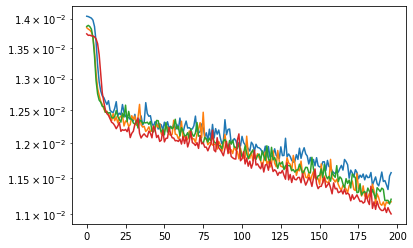

In [68]:
for l in los:
    plt.plot(l[3:])
plt.yscale('log')

## 1024-input test

In [69]:
rhos, losses = test_reg(nets, pooled_output_sum, targets, indices, "both")

In [70]:
rhos

{'stm': [0.44651438257589937,
  0.47554408545074683,
  0.46766048611285915,
  0.4631139678435276],
 'ltm': [0.2158929118965667,
  0.24249150403060063,
  0.22212516846906497,
  0.23629864451375351]}

In [71]:
mean(rhos["stm"]), mean(rhos["ltm"])

(0.4632082304957582, 0.22920205722749645)

## 2048-input train

In [73]:
nets_2, los_2 = train_reg(
    concat_pooled_output, 
    targets, 
    2048, 
    2, 
    indices, 
    SigLinNet, 
    BATCH_SIZE, 
    EPOCH, 
    lr,
    "both",
    512, 64, 32
)

Split 3: 100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


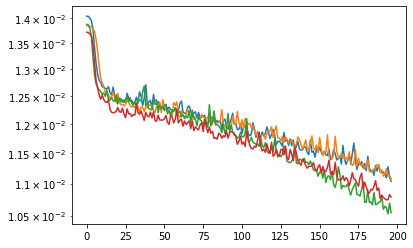

In [74]:
for l in los_2:
    plt.plot(l[3:])
plt.yscale('log')

## 2048-input test

In [76]:
rhos_2, losses_2 = test_reg(nets_2, concat_pooled_output, targets, indices, "both")

In [77]:
rhos_2

{'stm': [0.44047708554933207,
  0.4723136614637303,
  0.45800487540106927,
  0.47713459576054856],
 'ltm': [0.2098259251643052,
  0.23401166863995182,
  0.21126535858501036,
  0.2325589943398754]}

In [78]:
mean(rhos_2["stm"]), mean(rhos_2["ltm"])

(0.46198255454367004, 0.2219154866822857)